In [1]:
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
from classifiers.datasets.dataloader import Example_4x2
from classifiers.quantum.qasvm import QASVM
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils import QuantumInstance
from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
MAXITER = 2**10
LAST_AVG = 2**4
DATA_TYPE='unbalanced'
DEVICE = 'montreal'
DIR_NAME = 'ibmq_run_device_2'
TEST_SIZE=30

DATA_DIR = Path.home() /f'QUIC-Projects/{DIR_NAME}/{DATA_TYPE}/{DEVICE}'

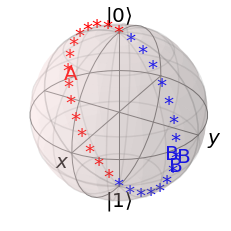

In [3]:
X, y = Example_4x2(DATA_TYPE=='balanced')()
ax = plt.axes(projection='3d')

from qiskit.visualization.bloch import Bloch
B = Bloch(axes=ax)

def s2c(x):
    bloch = [1, x[0], x[1]]
    r, theta, phi = bloch[0], bloch[1], bloch[2]
    bloch[0] = r * np.sin(theta) * np.cos(phi)
    bloch[1] = r * np.sin(theta) * np.sin(phi)
    bloch[2] = r * np.cos(theta)
    return bloch

def c2s(bloch):
    x = [np.arccos(bloch[2]), np.arctan(bloch[1]/bloch[0])]
    return x

vecs = np.array(list(map(s2c, X)))
for v in vecs[y==0]:
    B.add_annotation(v, text='A', color='r')
for v in vecs[y==1]:
    B.add_annotation(v, text='B', color='b')
# B.add_annotation(vecs.mean(axis=0), text='M', color='k')
vecA = vecs[y==0].mean(axis=0)
vecA = vecA/np.linalg.norm(vecA)
vecB = vecs[y==1].mean(axis=0)
vecB = vecB/np.linalg.norm(vecB)
vecP = (vecA-vecB)/np.linalg.norm(vecA-vecB)
vecQ = -(vecA-vecB)/np.linalg.norm(vecA-vecB)
#B.add_annotation(vecP, text='P', color='r')
#B.add_annotation(vecQ, text='Q', color='b')

def test_data_gen(n, vecP, vecQ):
    Xt = np.array([np.linspace(0, 2*np.pi, n+1), c2s(vecP)[1]*np.ones(n+1)]).T
    Xt = Xt[1:]
    yt = np.where(np.dot(np.array(list(map(s2c, Xt))), vecP-vecQ)<0, 1, 0)
    return Xt, yt

Xt, yt = test_data_gen(TEST_SIZE, vecP, vecQ)

vecs = np.array(list(map(s2c, Xt)))
for v in vecs[yt==0]:
    B.add_annotation(v, text='*', color='r')
for v in vecs[yt==1]:
    B.add_annotation(v, text='*', color='b')

B.render()

6
6


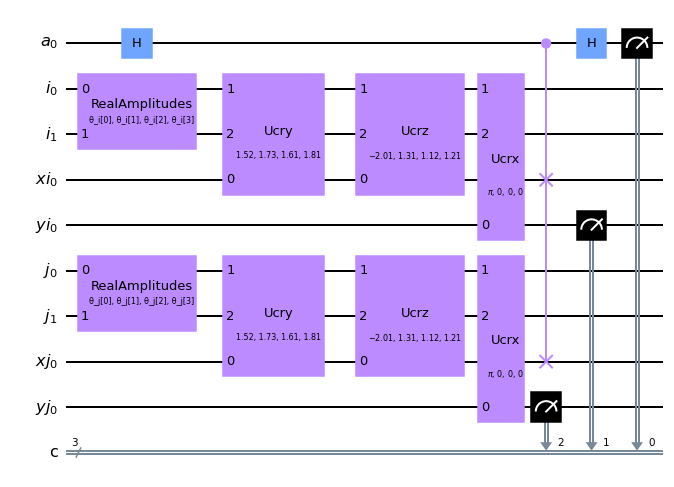

In [4]:
var_form = RealAmplitudes(2, reps=1)
quantum_instance = QuantumInstance(AerSimulator(), shots=2**13)
stc_qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).classifier
print(stc_qasvm.second_order_circuit.depth())
print(stc_qasvm.first_order_circuit.depth())
stc_qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

In [5]:
stc_storage = CostParamStorage()
optimizer = tSPSA(maxiter=MAXITER, blocking=True, last_avg=LAST_AVG, callback=stc_storage)

for epoch in tqdm(range(1, 32 + 1)):
    optimizer.step(stc_qasvm.cost_fn, stc_qasvm.parameters)
    if stc_storage.num_accepted() > 2 * LAST_AVG and stc_storage.last_cost_avg(2 * LAST_AVG, ignore_rejected=True) < stc_storage.last_cost_avg(LAST_AVG, ignore_rejected=True):
        break

stc_qasvm.parameters = stc_storage.last_avg(LAST_AVG, ignore_rejected=False)
stc_fvec = stc_qasvm.f(Xt)

stc_qasvm.save(DATA_DIR / 'stc_qasvm')
stc_storage.save(DATA_DIR / 'stc_storage')
np.save(DATA_DIR / 'stc_fvec.npy', stc_fvec)

  0%|          | 0/32 [00:00<?, ?it/s]

Text(0.5, 1.0, 'unbalanced')

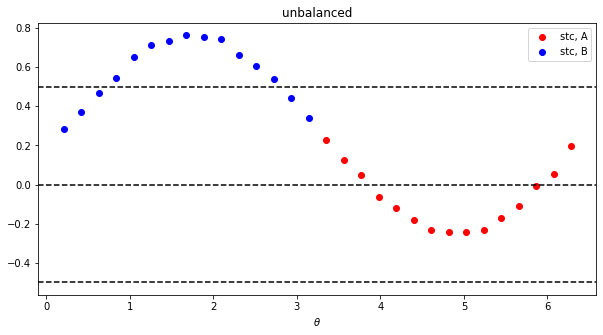

In [6]:
St = Xt[:, 0]
plt.figure(figsize=(10, 5))
plt.scatter(St[yt==0], stc_fvec[yt==0], c='r', marker='o', label='stc, A')
plt.scatter(St[yt==1], stc_fvec[yt==1], c='b', marker='o', label='stc, B')
plt.axhline(0, 0, 1, color='k', linestyle='--')
plt.axhline(-0.5, 0, 1, color='k', linestyle='--')
plt.axhline(+0.5, 0, 1, color='k', linestyle='--')
plt.legend()
plt.xlabel(r'$\theta$')
plt.title(DATA_TYPE)

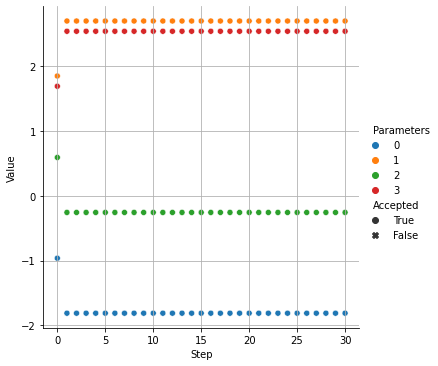

In [7]:
stc_storage.plot_params()

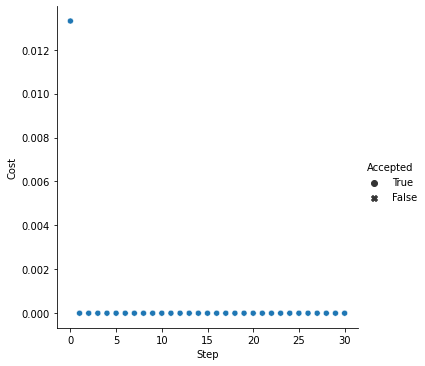

In [8]:
stc_storage.plot()